# Needed imports and utility

In [9]:
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from comtypes.client import CreateObject

import ansys.speos.core as core
from ansys.speos.core.speos import Speos
import ansys.speos.workflow as workflow

tests_data_path = os.path.join(os.path.join(os.path.abspath(''), os.path.pardir), "assets")

def print_message(msg):
    print(core.protobuf_message_to_str(msg))

def open_file(file):
    dpf_instance = None
    if file.endswith("xmp") or file.endswith("XMP"):
        dpf_instance = CreateObject("XMPViewer.Application")
        dpf_instance.OpenFile(file)
        res = dpf_instance.ExportXMPImage(file+".png", 1)
        if res:
            img = mpimg.imread(file+".png")
            plt.imshow(img)
            plt.axis("off")   # turns off axes
            plt.axis("tight")  # gets rid of white border
            plt.axis("image")  # square up the image instead of filling the "figure" space
            plt.show()
    elif file.endswith("hdr") or file.endswith("HDR"):
        dpf_instance = CreateObject("HDRIViewer.Application")
        dpf_instance.OpenFile(file)
        dpf_instance.Show(1)
    elif file.endswith("png") or file.endswith("PNG"):
        img = mpimg.imread(file)
        plt.imshow(img)
        plt.axis("off")   # turns off axes
        plt.axis("tight")  # gets rid of white border
        plt.axis("image")  # square up the image instead of filling the "figure" space
        plt.show()
    return dpf_instance

# Create connection with speos rpc server

In [10]:
speos = Speos(host="localhost", port=50051)
workflow.clean_all_dbs(speos.client)

# Create SpeosSimulationUpdate

In [11]:
sim_file = os.path.join(tests_data_path, "Prism", "Direct.1.speos")
ssu = workflow.SpeosSimulationUpdate(speos=speos, file_name=sim_file)
print(ssu.status)
print(ssu.scene)

Opened
ansys.api.speos.scene.v1.Scene
{
    "name": "Direct.1",
    "description": "From D:\\Work\\Gitdir\\pyspeos\\tests\\jupyter_notebooks\\..\\assets\\Prism\\Direct.1.speos",
    "part_guid": "be2cc71a-18b1-43ac-a232-4773e148e341",
    "vops": [
        {
            "vop_guid": "d55f5f51-9bfc-45ab-bcc2-d60689881e66",
            "geometries": {
                "geo_paths": [
                    "Solid:1692326488"
                ]
            },
            "name": "",
            "description": "",
            "metadata": {}
        }
    ],
    "sops": [
        {
            "sop_guid": "4a1771bb-fb76-4ef2-897b-97d2d5989fad",
            "geometries": {
                "geo_paths": [
                    "Solid:1692326488/face.1:242396665"
                ]
            },
            "name": "",
            "description": "",
            "metadata": {}
        },
        {
            "sop_guid": "252171dd-d09b-474a-9004-beda14578047",
            "geometries": {
                

# New Irradiance sensor
## Create two IrradianceSensorParameters

In [12]:
sensors = []

irradiance_sensor = workflow.IrradianceSensorParameters() # use default parameters
sensors.append(irradiance_sensor)

irradiance_sensor_new = irradiance_sensor.copy() # assign values to parameters
irradiance_sensor_new.name = "new_sensor"
irradiance_sensor_new.integration_type = core.SensorTemplateFactory.IlluminanceType.Planar
irradiance_sensor_new.type = core.SensorTemplateFactory.Type.Spectral
irradiance_sensor_new.wavelengths_start = 380
irradiance_sensor_new.wavelengths_end = 780
irradiance_sensor_new.wavelengths_sampling = 41
irradiance_sensor_new.x_range_start = -40
irradiance_sensor_new.x_range_end = 40
irradiance_sensor_new.x_range_sampling = 400
irradiance_sensor_new.y_range_start = -5
irradiance_sensor_new.y_range_end = 5
irradiance_sensor_new.y_range_sampling = 100
sensors.append(irradiance_sensor_new)


# Create IrradianceSensorProperties

In [13]:
irradiance_props = workflow.IrradianceSensorProperties()
irradiance_props.origin = [921.36, 0, 388.72]
irradiance_props.x_vector = [0.388721970152395, 0, -0.921355105223193]
irradiance_props.y_vector = [0.0, 1.0, 0.0]
irradiance_props.z_vector = [0.921355105223193, 0.0, 0.388721970152395]

# Add Irradiance sensors to simulation

In [14]:
for sensor in sensors:
    ssu.add_irradiance_sensor(sensor, irradiance_props)

# Compute simulation

██████████████████████████████████████████████████| 100.
ansys.api.speos.job.v2.GetResults_Response
{
    "results": [
        {
            "path": "C:\\Users\\sthoene\\AppData\\Local\\Temp\\jobs\\84138841-86c9-4212-979c-1fce8132a80a\\Direct.1.Irradiance.1.xmp"
        },
        {
            "path": "C:\\Users\\sthoene\\AppData\\Local\\Temp\\jobs\\84138841-86c9-4212-979c-1fce8132a80a\\irradiance sensor.1.xmp"
        },
        {
            "path": "C:\\Users\\sthoene\\AppData\\Local\\Temp\\jobs\\84138841-86c9-4212-979c-1fce8132a80a\\new_sensor.1.xmp"
        },
        {
            "path": "C:\\Users\\sthoene\\AppData\\Local\\Temp\\jobs\\84138841-86c9-4212-979c-1fce8132a80a\\Direct.1.html"
        }
    ]
}


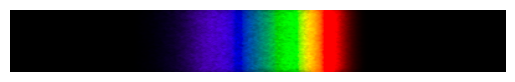

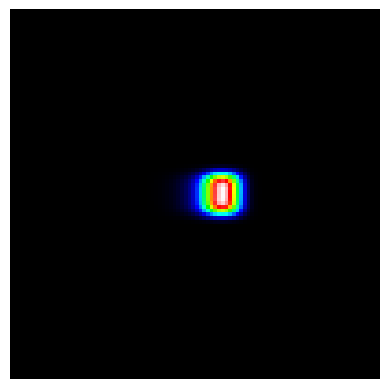

In [15]:
job_link = ssu.compute("first_job")
print_message(job_link.get_results())
open_file(job_link.get_results().results[2].path)
open_file(job_link.get_results().results[1].path)

# Modify the irradiance sensor

In [16]:
irradiance_sensor_update = irradiance_sensor_new.copy()

irradiance_props_update = workflow.IrradianceSensorProperties()
irradiance_props_update.origin = [1000, 0, 400]
irradiance_props_update.x_vector = [0.388721970152395, 0, -0.921355105223193]
irradiance_props_update.y_vector = [0.0, 1.0, 0.0]
irradiance_props_update.z_vector = [0.921355105223193, 0.0, 0.388721970152395]

ssu.update_sensor(irradiance_sensor_update, irradiance_props_update)

# Compute the modified simulation

██████████████████████████████████████████████████| 100.
ansys.api.speos.job.v2.GetResults_Response
{
    "results": [
        {
            "path": "C:\\Users\\sthoene\\AppData\\Local\\Temp\\jobs\\96f858ce-c4b3-4f3b-8e20-958501451101\\Direct.1.Irradiance.1.xmp"
        },
        {
            "path": "C:\\Users\\sthoene\\AppData\\Local\\Temp\\jobs\\96f858ce-c4b3-4f3b-8e20-958501451101\\irradiance sensor.1.xmp"
        },
        {
            "path": "C:\\Users\\sthoene\\AppData\\Local\\Temp\\jobs\\96f858ce-c4b3-4f3b-8e20-958501451101\\new_sensor.1.xmp"
        },
        {
            "path": "C:\\Users\\sthoene\\AppData\\Local\\Temp\\jobs\\96f858ce-c4b3-4f3b-8e20-958501451101\\Direct.1.html"
        }
    ]
}


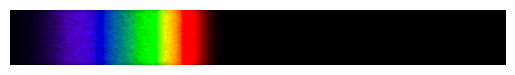

In [17]:
job_link = ssu.compute("second_job")
print_message(job_link.get_results())
open_file(job_link.get_results().results[2].path)

# Compute the modified simulation using GPU

██████████████████████████████████████████████████| 100.
ansys.api.speos.job.v2.GetResults_Response
{
    "results": [
        {
            "path": "C:\\Users\\sthoene\\AppData\\Local\\Temp\\jobs\\93163a39-0279-4db7-be68-3acf8891aab4\\Direct.1.Irradiance.1.xmp"
        },
        {
            "path": "C:\\Users\\sthoene\\AppData\\Local\\Temp\\jobs\\93163a39-0279-4db7-be68-3acf8891aab4\\irradiance sensor.1.xmp"
        },
        {
            "path": "C:\\Users\\sthoene\\AppData\\Local\\Temp\\jobs\\93163a39-0279-4db7-be68-3acf8891aab4\\new_sensor.1.xmp"
        },
        {
            "path": "C:\\Users\\sthoene\\AppData\\Local\\Temp\\jobs\\93163a39-0279-4db7-be68-3acf8891aab4\\Direct.1.html"
        }
    ]
}


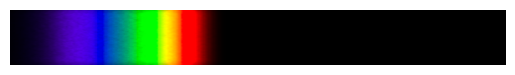

In [18]:
job_link = ssu.compute("second_job", compute_type="gpu")
print_message(job_link.get_results())
open_file(job_link.get_results().results[2].path)

# Clean after usage

In [8]:
job_link.delete()
ssu.close()
print(ssu.status)

Closed
